<a href="https://colab.research.google.com/github/PengJuan-AI/TensorFlow_Study/blob/main/05_transfer_learning_in_tensorflow_part2_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow Part 2: Fine Tuning

In the previous notebook, we covered transfer learning feature extraction, now it's time to learn about a new kind of transfer learning: fine-tuning

links for more details: https://keras.io/guides/transfer_learning/#transfer-learning-amp-finetuning

What we're going to cover:
* Introduce **fine-tuning learning** with TensorFlow
* Introduce the **Keras Functional API** to build model
* Using a small dataset to experiment faster
* **Data augmentation**
* Running a series of experiments on our Food Vision Data
* Introduce the **ModelCheckPoint callback** to save intermediate training results.

In [1]:
!pip uninstall -y tensorflow to remove the 2.12.x version

Found existing installation: tensorflow 2.12.0
Uninstalling tensorflow-2.12.0:
  Successfully uninstalled tensorflow-2.12.0


In [2]:
!pip install -U -q tensorflow==2.9.0
import tensorflow as tf
print(tf.__version__)
from tensorflow import keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 MB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 83.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 105.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 43.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 57.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 83.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 57.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-datasets 4.9.2 requires protobuf>=3.20, but you have protobuf 3.19.6 which is incompatible.
tensorflow-metadata 1.14.0 requires protobuf<4.21,>=3.20.3, but you have protobuf 

## Creating helper functions

Use the helper functions used in previous notebooks. It's a good idea to put functions you'll want to use again in a script you can dowload and import into your notebooks

In [3]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-08-17 18:40:23--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-08-17 18:40:24 (67.3 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [4]:
# import helper functions
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

> **Note:** If you're running this notebook in Google Colab, when it's time out, it will delete `helper_functions`, you wil need to re-run and re-download these helper functions.

## Let's get some data

This time we're going to see how we can use the pretrained models within `tf.keras.applications` and apply them to our own problem.

link: https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [5]:
# Get 10% of food training data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2023-08-17 18:40:25--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.10.128, 142.251.12.128, 172.217.194.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.10.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  22.2MB/s    in 7.9s    

2023-08-17 18:40:33 (20.5 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [6]:
# CHECK HOW MANY IMAGES AND SUBDIRECTORIES
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/trai

In [7]:
# Create training and test directories paths
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

This tim we're using `tf.keras.preprocessing.image_dataset_from_directory`.

Descriptions: Then calling **`image_dataset_from_directory`** will return a `tf.data.Dataset` that yields batches of images from the subdirectories, together with labels 0 and 1. https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory

In [8]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir, image_size=IMG_SIZE,
                                                                 label_mode="categorical",
                                                                 batch_size=BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir, image_size=IMG_SIZE,
                                                                label_mode = 'categorical',
                                                                batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [9]:
# Datatype: BatchDataset (each batch will be a batch of BATCH_SIZE images)
train_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [10]:
# Class names of our dataset
train_data.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [11]:
# See an example of a batch of data
for images, labels in train_data.take(1):
  print(images.shape, labels.shape)

(32, 224, 224, 3) (32, 10)


## Creating the model 0:
1. Building a transfer learning feature extraction model
2. using the Keras Functional API

### Keras Sequential vs. Functional API
Similarities: compiling, fitting, evaluating.

Differencies: model construction (the **Functional API is more flexible** and able to produce more sophisticated models)

In [20]:
from os.path import dirname
# 1. Create a base model (we don't include the top here because we are going to add our own Dense layer)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the underlying pre-trained patterns aren't updatted during training)
base_model.trainable=False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224,224,3), name="input_layer")

# 4. If using a model like ResNet50V2, you will need to normalize inputs (EfficientNet don't require)
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1/255.)(inputs)

# 5. Pass the inputs to the base model
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation='softmax', name="output_layer")(x)

# 8. Combine the inpouts with the outputs into our model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# 10. Fit the model
history_0 = model_0.fit(train_data, epochs=5, steps_per_epoch=len(train_data),
            validation_data=test_data,
            validation_steps=int(0.25*len(test_data)), # only test 25% of the test data so we can train faster
            callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                   experiment_name="10_percent_feature_extraction")])

Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20230817-184345
Epoch 1/5
24/24 [==============================] - 11s 245ms/step - loss: 1.8604 - accuracy: 0.4440 - val_loss: 1.2457 - val_accuracy: 0.7352
Epoch 2/5
24/24 [==============================] - 8s 325ms/step - loss: 1.0791 - accuracy: 0.7667 - val_loss: 0.8535 - val_accuracy: 0.8141
Epoch 3/5
24/24 [==============================] - 6s 212ms/step - loss: 0.7898 - accuracy: 0.8133 - val_loss: 0.7002 - val_accuracy: 0.8273
Epoch 4/5
24/24 [==============================] - 5s 182ms/step - loss: 0.6353 - accuracy: 0.8507 - val_loss: 0.6147 - val_accuracy: 0.8487
Epoch 5/5
24/24 [==============================] - 5s 180ms/step - loss: 0.5459 - accuracy: 0.8747 - val_loss: 0.5662 - val_accuracy: 0.8553


In [21]:
# Evaluate on the full test dataset
model_0.evaluate(test_data)

79/79 [==============================] - 8s 88ms/step - loss: 0.5603 - accuracy: 0.8596


[0.5603271722793579, 0.8596000075340271]

In [14]:
# # Check the layers in our base model
# for layer_number, layer in enumerate(base_model.layers):
#   print(layer_number, layer.name)

In [15]:
# How about we get a summary of the base model
# EfficientB0 has its own rescaling and normalization layers.
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

In [16]:
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


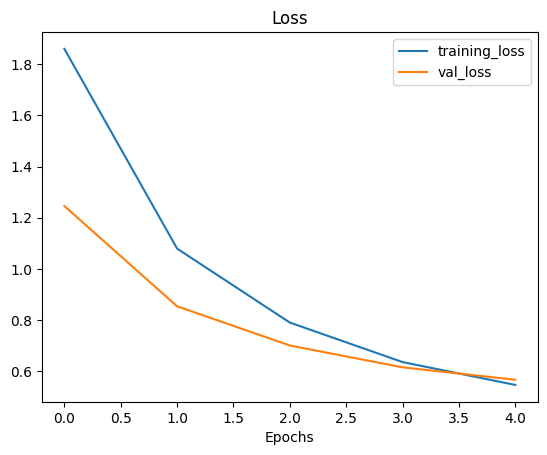

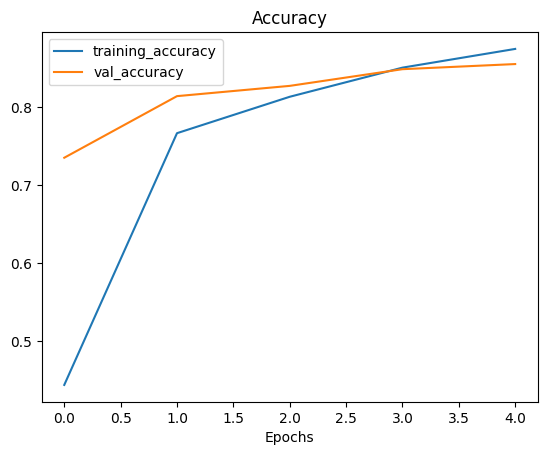

In [22]:
# Check our loss curves
plot_loss_curves(history_0)
# model_0.history['loss']

## Getting a feature vector from a trained model

Let's demonstrate the Global Average Pooling 2D layer...

We have a tensor after our model goes through `base_model` of shape (None, 7, 7, 1280).

But then when it passes through GlobalAveragePooling2D, it turns into (None, 1280).

Use a similar shaped tensor of (1, 4, 4, 3) and then pass it through `GlobalAveragePooling2D`.

### What is feature vector?
A feature vector (same shape as number of classes) is a **learned representation of the input data**. Specifically, the densed/compressed process happens in Pooling layer.


In [23]:
# Define a input shape
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
input_tensor

<tf.Tensor: shape=(1, 4, 4, 3), dtype=float32, numpy=
array([[[[ 0.3274685 , -0.8426258 ,  0.3194337 ],
         [-1.4075519 , -2.3880599 , -1.0392479 ],
         [-0.5573232 ,  0.539707  ,  1.6994323 ],
         [ 0.28893656, -1.5066116 , -0.2645474 ]],

        [[-0.59722406, -1.9171132 , -0.62044144],
         [ 0.8504023 , -0.40604794, -3.0258412 ],
         [ 0.9058464 ,  0.29855987, -0.22561555],
         [-0.7616443 , -1.8917141 , -0.93847126]],

        [[ 0.77852213, -0.47338897,  0.97772694],
         [ 0.24694404,  0.20573747, -0.5256233 ],
         [ 0.32410017,  0.02545409, -0.10638497],
         [-0.6369475 ,  1.1603122 ,  0.2507359 ]],

        [[-0.41728503,  0.4012578 , -1.4145443 ],
         [-0.5931857 , -1.6617213 ,  0.33567193],
         [ 0.10815629,  0.23479682, -0.56668764],
         [-0.35819843,  0.88698614,  0.52744764]]]], dtype=float32)>

In [24]:
# Pass the random tensor through the GlobalAveragePooling2D layer
global_averaged_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_averaged_pooled_tensor}\n")

2D global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]



In [25]:
# Check the shape of the different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"SHape of global average pooled tensor: {global_averaged_pooled_tensor.shape}")

Shape of input tensor: (1, 4, 4, 3)
SHape of global average pooled tensor: (1, 3)


What `GlobalAveragePooling2D` layer do is to condense a tensor into a vector (input to a final output dense)

> **Note:** One of thereasons feature extraction transfer learning is named is because what often happens is pretrained model outputs a **feature vector**, which can then be used to exteact patterns out of our own problem

In [26]:
# Let's replicate the operation
tf.reduce_mean(input_tensor, axis=[1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

🛠 Practice: Do the same as the above cell but for `tf.keras.layers.GlobalMaxPool2D()`.

In [27]:
global_max_pooled_tensor = tf.keras.layers.GlobalMaxPool2D()(input_tensor)
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of the global max pooled tensor: {global_max_pooled_tensor.shape}")

Shape of input tensor: (1, 4, 4, 3)
Shape of the global max pooled tensor: (1, 3)


In [28]:
global_max_pooled_tensor

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.9058464, 1.1603122, 1.6994323]], dtype=float32)>

In [29]:
# replicate GlobalMaxPool2D
tf.reduce_max(input_tensor, axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.9058464, 1.1603122, 1.6994323]], dtype=float32)>

## Runing a series of transfer learning

We've seen the incredible results transfer learning can get with only 10% of the training data. Let's check its performance on 1% of training data.

1. `model_1` -  use feature extraction transfer learning with 1% training data with data augmentation.
2. `model_2` - use feature extraction transfer learning with 10% training data with data augmentation.
3. `model_3` - use fine-tuning transfer learning on 10% of the training data with data augmentation
4. `model_4` - use fine-tuning learning on 100% of traininig data with data augmentation

(gradually increase the size of training data) - Only lots of experiments can tell you how to gradually set up your models.

> **Note:** Throughout all experiments the same test dataset will be used to evaluate the model, this ensures consistency across evaluation metrics.



### Getting and preprocessing data for model_1

In [30]:
# Download and unzip data - preprocessed from Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

unzip_data("10_food_classes_1_percent.zip")

--2023-08-17 18:44:44--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.24.128, 142.251.10.128, 142.251.12.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.24.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M  21.3MB/s    in 7.3s    

2023-08-17 18:44:52 (17.6 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [31]:
# Create training and test dir
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir = "10_food_classes_1_percent/test"

In [32]:
# How many images we're wotking with
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There a

In [33]:
IMG_SIZE = (224, 224)
train_data_1_pct = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                       label_mode='categorical',
                                                                       image_size=IMG_SIZE,
                                                                       batch_size=BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode='categorical',
                                                                image_size=IMG_SIZE,
                                                                batch_size=BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


### Add data augmentation as an inner layer

To add data augmentation right into our model, we can use the layers inside:
 * `tf.keras.layers.experimental.preprocessing()`

 We can see the benefits and useages of doing preprocessing here: https://www.tensorflow.org/tutorials/images/data_augmentation#two_options_to_use_the_keras_preprocessing_layers

 After reading the doc, the benefits of using data augmentation inside the model are:
 * Preprocessing of images happens on the GPU (much faster) ranther than the CPU;
 * Image data augmentation only happens during the training, so we can still export our whole model (wiht data augmentation layer) and use it elsewhere

 > 💡When passed as a layer to a model data augementation is automatically turned on during training (augments training data) but turned off during inference (does not augment testing data or new unseen data).

In [34]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create data augmentation stage with horizontal flipping, rotations, zoom, etc.
data_augmentation = keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    # preprocessing.Rescaling(1/255.) # Keep for model like ResNet50V2
], name="data_augmentation")

### Visualize our data augmentation layer (and see what happens)

10_food_classes_1_percent/train/chicken_curry/3808493.jpg


(-0.5, 511.5, 511.5, -0.5)

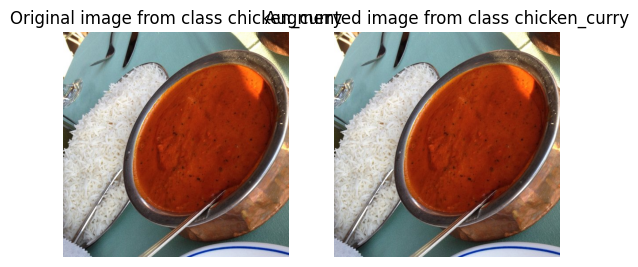

In [35]:
# View a random image and compare it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_pct.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + '/' + random_image

print(random_image_path)
# Read in the random image
img = mpimg.imread(random_image_path)
plt.subplot(1,2,1)
plt.imshow(img)
plt.title(f"Original image from class {target_class}")
plt.axis(False)

# Plot our augmented image
augmented_img = data_augmentation(tf.expand_dims(img,axis=0)) # data augmentation requires input shape of (None, height, width, color_channels)
plt.subplot(1,2,2)
plt.imshow(tf.squeeze(augmented_img)/255.) # need to normalize it before imshow
plt.title(f"Augmented image from class {target_class}")
plt.axis(False)


## Model 1: Feature extraction transfer learning on 1% of the data with data augmentation

In [36]:
# Set up input shape and base model, freezing the base model layers
# also work: IMG_SIZE+(3,)
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False # it is a pretrained model on ImageNet and we want to keep the learned pattern

# Create a input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model the augmented input data and don't train it
x = base_model(x, training=False)

# Pool output features of the base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model using the inputs and outputs
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_1_pct = model_1.fit(train_data_1_pct,
                            epochs=5,
                            steps_per_epoch=len(train_data_1_pct),
                            validation_data=test_data,
                            validation_steps=int(0.25*len(test_data)),
                            callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                   experiment_name="1_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20230817-184457
Epoch 1/5
3/3 [==============================] - 10s 2s/step - loss: 2.4154 - accuracy: 0.1000 - val_loss: 2.2314 - val_accuracy: 0.1974
Epoch 2/5
3/3 [==============================] - 4s 2s/step - loss: 2.1759 - accuracy: 0.2429 - val_loss: 2.1001 - val_accuracy: 0.3010
Epoch 3/5
3/3 [==============================] - 3s 1s/step - loss: 1.9867 - accuracy: 0.4143 - val_loss: 1.9811 - val_accuracy: 0.3635
Epoch 4/5
3/3 [==============================] - 4s 2s/step - loss: 1.7727 - accuracy: 0.4857 - val_loss: 1.8742 - val_accuracy: 0.4605
Epoch 5/5
3/3 [==============================] - 7s 3s/step - loss: 1.5798 - accuracy: 0.6571 - val_loss: 1.7784 - val_accuracy: 0.5197


In [37]:
model_1.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [38]:
# Evaluate our model_1 on th whole test dataset
model_1.evaluate(test_data)

79/79 [==============================] - 6s 69ms/step - loss: 1.7842 - accuracy: 0.4920


[1.7842127084732056, 0.492000013589859]

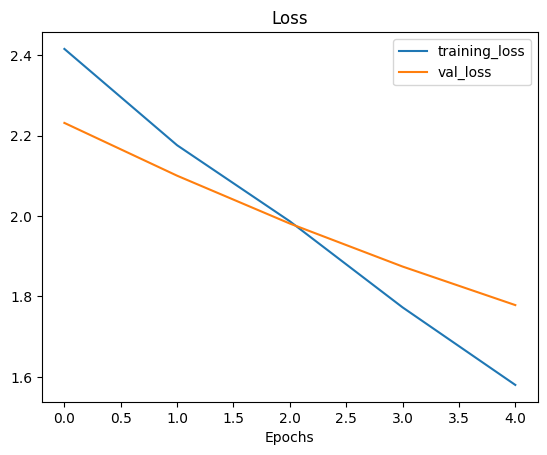

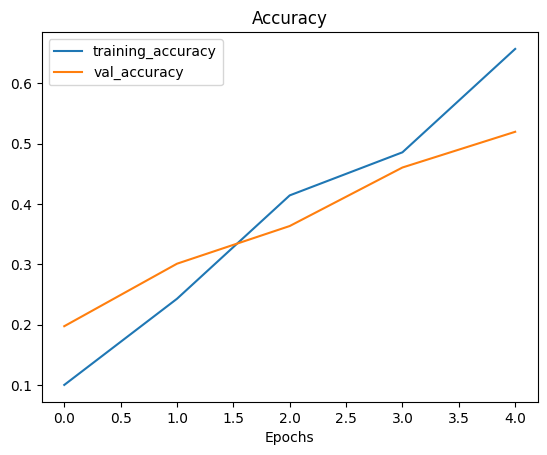

In [39]:
# Plot loss curves
plot_loss_curves(history_1_pct)

## Model 2: Feature extraction transfer learning model with 10% of data and data augmentation


In [40]:
# Get 10% of food training data
# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# unzip_data("10_food_classes_10_percent.zip")

In [41]:
train_dir_10_pct = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [42]:
# Set up data inputs
IMG_SIZE = (224, 224)
train_data_10_pct = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_pct,
                                                                        label_mode="categorical",
                                                                        image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)


Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [43]:
data_augmentation.summary()

Model: "data_augmentation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, None, None, 3)     0         
                                                                 
 random_rotation (RandomRota  (None, None, None, 3)    0         
 tion)                                                           
                                                                 
 random_zoom (RandomZoom)    (None, None, None, 3)     0         
                                                                 
 random_height (RandomHeight  (None, None, None, 3)    0         
 )                                                               
                                                                 
 random_width (RandomWidth)  (None, None, None, 3)     0         
                                                                 
Total params: 0
Trainable params: 0
Non-trainable

In [44]:
# Create model 2 with data augmentation built in
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Build data augmentation layer
# data_augmentation = Sequential([
#     preprocessing.RandomFlip("horizontal"),
#     ...
# ])

# inputs shape
input_shape = (224,224,3)

# create a frozon base model (also called the backbone)
base_model = tf.keras.applications.EfficientNetB0(include_top=False) # put custom top layer on the model top
base_model.trainable = False

# Create the inouts and outputs
inputs = layers.Input(shape=input_shape, name='input_layer')
x = data_augmentation(inputs)
x = base_model(x, training=False) # pass the augmented images to base model but keep the base model in inference mode, this also ensures batchnorm layers don't get updated
x = layers.GlobalAveragePooling2D(name="global_average_pooling_2D")(x)
outputs = layers.Dense(10, activation='softmax', name="output_layer")(x)

model_2 = tf.keras.Model(inputs, outputs)

# Compile
model_2.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=["accuracy"])

In [45]:
model_2.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_2D (  (None, 1280)             0         
 GlobalAveragePooling2D)                                         
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

### Create a ModelCheckpoint callbacks

`tf.keras.ModelCheckpoint` - Callback to save the Keras model weights at some frequency, save the full model or just the weights during training.

```python
tf.keras.callbacks.ModelCheckpoint(
    filepath, monitor: str = 'val_loss',
    verbose: int = 0,
    save_best_only: bool = False,
    save_weights_only: bool = False,
    mode: str = 'auto',
    save_freq='epoch',
    options=None,
    initial_value_threshold=None,
    **kwargs
)
```

This is useful because we can come and start where we left off.

In [46]:
# Set checkpoint path
checkpoint_path = "10_pct_model_checkpoints_weights/checkpoint"

# Create a ModelCheckpoint Callback that saves the model's weights only (quicker)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=False, # if it is ture, it will only save weights that results the smallest val_loss (default)
                                                         save_freq='epoch', # save every epoch
                                                         verbose=1)

In [47]:
# Fit the model saving checkpoint every epoch
initial_epochs = 5
history_10_pct_data_aug = model_2.fit(train_data_10_pct, epochs=5,
                                      steps_per_epoch=len(train_data_10_pct),
                                      validation_data=test_data,
                                      validation_steps=int(0.25*len(test_data)),
                                      callbacks=[
                                          create_tensorboard_callback(dir_name="transfer_learning",
                                                                      experiment_name="10_percent_data_aug"),
                                          checkpoint_callback
                                      ])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20230817-184543
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 1.9526 - accuracy: 0.3680
Epoch 1: saving model to 10_pct_model_checkpoints_weights/checkpoint
24/24 [==============================] - 19s 513ms/step - loss: 1.9526 - accuracy: 0.3680 - val_loss: 1.4554 - val_accuracy: 0.6908
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.2879 - accuracy: 0.7027
Epoch 2: saving model to 10_pct_model_checkpoints_weights/checkpoint
24/24 [==============================] - 11s 472ms/step - loss: 1.2879 - accuracy: 0.7027 - val_loss: 0.9908 - val_accuracy: 0.7911
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 0.9838 - accuracy: 0.7760
Epoch 3: saving model to 10_pct_model_checkpoints_weights/checkpoint
24/24 [==============================] - 15s 597ms/step - loss: 0.9838 - accuracy: 0.7760 - val_loss: 0.8028 - val_accuracy: 0.8158
Epoch 4/5
24/24 [==============

In [48]:
model_2.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_2D (  (None, 1280)             0         
 GlobalAveragePooling2D)                                         
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [49]:
model_0.evaluate(test_data)

79/79 [==============================] - 6s 70ms/step - loss: 0.5603 - accuracy: 0.8596


[0.5603270530700684, 0.8596000075340271]

In [50]:
results_10_pct_data_aug = model_2.evaluate(test_data)
results_10_pct_data_aug

79/79 [==============================] - 8s 94ms/step - loss: 0.6233 - accuracy: 0.8384


[0.6232821941375732, 0.8384000062942505]

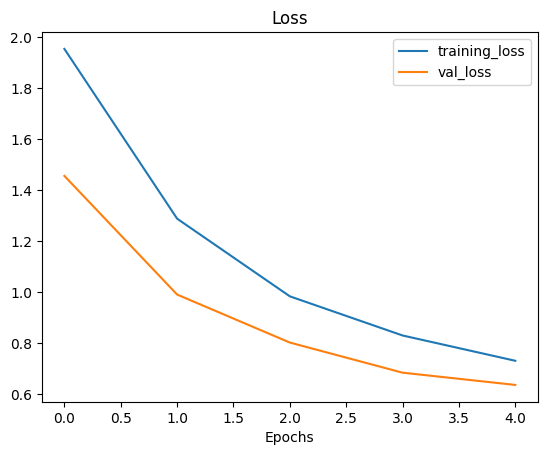

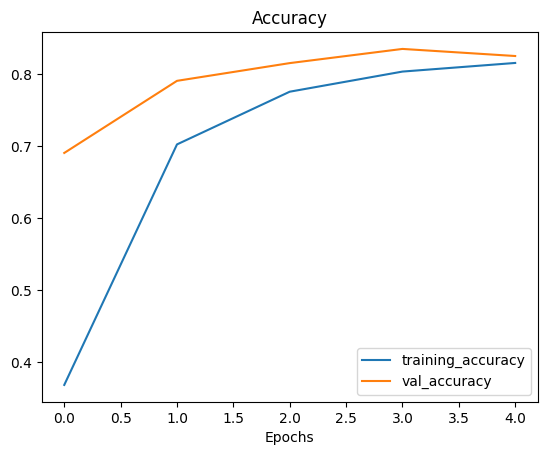

In [51]:
plot_loss_curves(history_10_pct_data_aug)

### Loading in checkpointed weights

Loading in checkpointed weights returns a model to a specifiv checkpoint.

Value of checkpoints:

In [52]:
# Load in saved model weights and evaluate it on test_data
model_2.load_weights(checkpoint_path)

In [53]:
# Evaluate model_2 with loaded weights
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 8s 90ms/step - loss: 0.6233 - accuracy: 0.8384


In [54]:
# If the results from our previously evaluated model_2 match the loaded weights, it works!
results_10_pct_data_aug == loaded_weights_model_results

False

At this point we've play with the transfer learning model - EfficientNetB0 - on 1% and 10% of training data. Also, we've tried to use TensorBoard and ModelCheckpoint callbacks in our fitting.

What's next is to fine-tuning the pretrained model!


## Model 3: Fine-tuning an existing model on 10% of the data

In fine-tuining, some layers of the pretrained model stay the same, while some layers will be unfrozen and be customized. Usually, we change layers that are close to the output layer because the bottom layers learn more general patterns of data.

> Fine-tuning usually works best *after* training a feature extraction model for a few epochs with large amounts of custom data

In [55]:
# Layers in loaded model
for layer in model_2.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7ec8c1208d90> True
<keras.engine.sequential.Sequential object at 0x7ec8b671c1f0> True
<keras.engine.functional.Functional object at 0x7ec8a7f1a290> False
<keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7ec8b6805a80> True
<keras.layers.core.dense.Dense object at 0x7ec8a7e260b0> True


In [56]:
# What layers are in our base model (EfficientNetB0) and are they trainable
for i, layer in enumerate(model_2.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_4 False
1 rescaling_3 False
2 normalization_3 False
3 tf.math.truediv_3 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeez

In [57]:
# To begin with, let's start by setting the last 10 layers of our base_model to trainable
base_model.trainable = True

# Freeze all layers except for the last 10
for layer in base_model.layers[:-10]:
  layer.trainable = False

# Recompile (we have to recompile our model every time we make a change)
model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # when fine-tuning, you would wan to lower the learning rate by 10x
                metrics=["accuracy"])

> **Note:** When using finr-tuning, it's best practice to lower your learning rate by some amount, in order not to change the weights of pretrained model too much.

A good resources for information on this is the UMLFiT paper:

In [58]:
# from keras.saving.serialization_lib import enable_unsafe_deserialization
# Check which layers are trainable
for layer_number , layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.trainable)

0 False
1 False
2 False
3 False
4 False
5 False
6 False
7 False
8 False
9 False
10 False
11 False
12 False
13 False
14 False
15 False
16 False
17 False
18 False
19 False
20 False
21 False
22 False
23 False
24 False
25 False
26 False
27 False
28 False
29 False
30 False
31 False
32 False
33 False
34 False
35 False
36 False
37 False
38 False
39 False
40 False
41 False
42 False
43 False
44 False
45 False
46 False
47 False
48 False
49 False
50 False
51 False
52 False
53 False
54 False
55 False
56 False
57 False
58 False
59 False
60 False
61 False
62 False
63 False
64 False
65 False
66 False
67 False
68 False
69 False
70 False
71 False
72 False
73 False
74 False
75 False
76 False
77 False
78 False
79 False
80 False
81 False
82 False
83 False
84 False
85 False
86 False
87 False
88 False
89 False
90 False
91 False
92 False
93 False
94 False
95 False
96 False
97 False
98 False
99 False
100 False
101 False
102 False
103 False
104 False
105 False
106 False
107 False
108 False
109 False
110 False


In [59]:
# Now we've unfrozen some of the layers close to the top (last 10)
print(len(model_2.layers[2].trainable_variables))

10


### Fine-tune model_2

Specifically, model 3 is the further training on model 2 for 5 epochs

`initial_epochs=history_10_pct_data_aug.epoch[-1]`: model_2 have already been trained for 5 epochs, now we just train for 5 more epochs based on what have done. `initial_epochs` means starting training from some point.

In [60]:
# Fine-tune for another 5 epochs
fine_tune_epochs = initial_epochs+5

# Refit the model (same as model_2 except with more trainable layers)
# model_2 is a feature extraction model
history_fine_tune_10_pct_data_aug = model_2.fit(train_data_10_pct,
                                                epochs=fine_tune_epochs,
                                                validation_data=test_data,
                                                validation_steps=int(0.25*len(test_data)),
                                                initial_epoch=history_10_pct_data_aug.epoch[-1], # start training from previous last epochs
                                                callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                       experiment_name="10_percent_fine_tune_last_10_layers")])

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10_layers/20230817-184727
Epoch 5/10
24/24 [==============================] - 21s 560ms/step - loss: 0.6116 - accuracy: 0.8440 - val_loss: 0.5042 - val_accuracy: 0.8618
Epoch 6/10
24/24 [==============================] - 10s 412ms/step - loss: 0.4865 - accuracy: 0.8600 - val_loss: 0.4698 - val_accuracy: 0.8520
Epoch 7/10
24/24 [==============================] - 12s 490ms/step - loss: 0.4119 - accuracy: 0.8693 - val_loss: 0.4503 - val_accuracy: 0.8536
Epoch 8/10
24/24 [==============================] - 9s 371ms/step - loss: 0.3876 - accuracy: 0.8907 - val_loss: 0.4367 - val_accuracy: 0.8684
Epoch 9/10
24/24 [==============================] - 12s 489ms/step - loss: 0.3360 - accuracy: 0.9027 - val_loss: 0.4382 - val_accuracy: 0.8602
Epoch 10/10
24/24 [==============================] - 11s 436ms/step - loss: 0.3046 - accuracy: 0.8987 - val_loss: 0.4363 - val_accuracy: 0.8668


In [61]:
# Evaluate the fine-tune model
results_fine_tune_10_pct = model_2.evaluate(test_data)

79/79 [==============================] - 6s 70ms/step - loss: 0.4137 - accuracy: 0.8608


In [62]:
results_10_pct_data_aug

[0.6232821941375732, 0.8384000062942505]

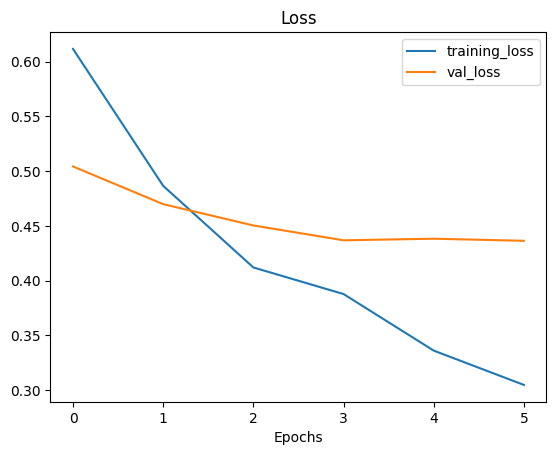

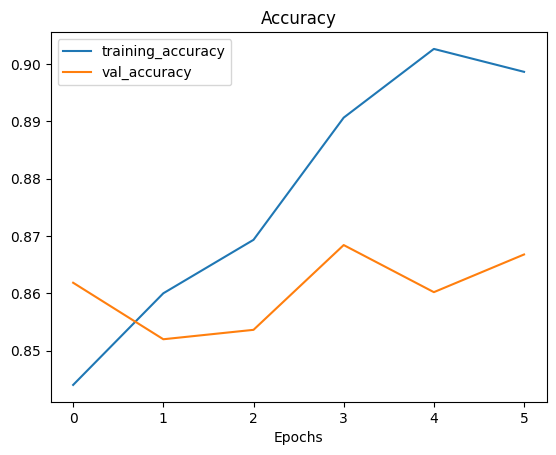

In [63]:
# Check out the loss curves of our fine-tune model
plot_loss_curves(history_fine_tune_10_pct_data_aug)

The `plot_loss_curves` works great with models whcih have only been trained for once, however, we want something to compare on series of running `fit()` with another. (e.g before and after fine-tuning)

In [64]:
# creata function to compare training histories
def compare_histories(origin_hist, new_hist, initial_epochs=5):
  """
  Compare two TensorFlow History object.
  origin_hist: history before fine-tuning for example
  new_hist: history after fine_tuning
  """
  # Get original history measurements
  acc = origin_hist.history["accuracy"]
  loss = origin_hist.history["loss"]

  val_acc = origin_hist.history["val_accuracy"]
  val_loss = origin_hist.history["val_loss"]

  # Combine original history metrics with new history metrics
  total_acc = acc + new_hist.history["accuracy"]
  total_loss = loss + new_hist.history["loss"]

  total_val_acc = val_acc + new_hist.history["val_accuracy"]
  total_val_loss = val_loss + new_hist.history["val_loss"]

  # Make plots for accuracy
  plt.figure(figsize=(8,8))
  plt.subplot(2,1,1)
  plt.plot(total_acc, label="Training Accuracy")
  plt.plot(total_val_acc, label="Val Accuracy")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning")
  plt.legend(loc="lower right")
  plt.title("Training and Validation Accuracy")

  # Make plots for loss
  plt.figure(figsize=(8,8))
  plt.subplot(2,1,2)
  plt.plot(total_loss, label="Training Loss")
  plt.plot(total_val_loss, label="Val Loss")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning")
  plt.legend(loc="upper right")
  plt.title("Training and Validation Loss")

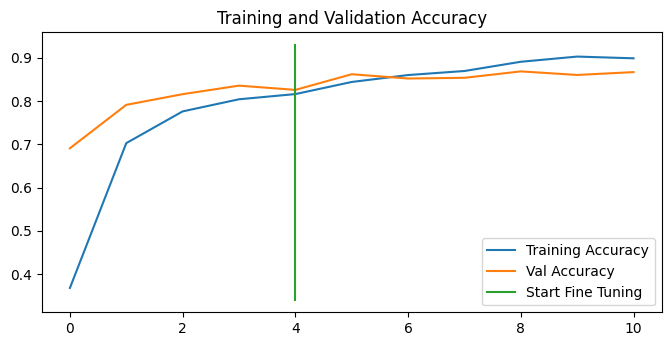

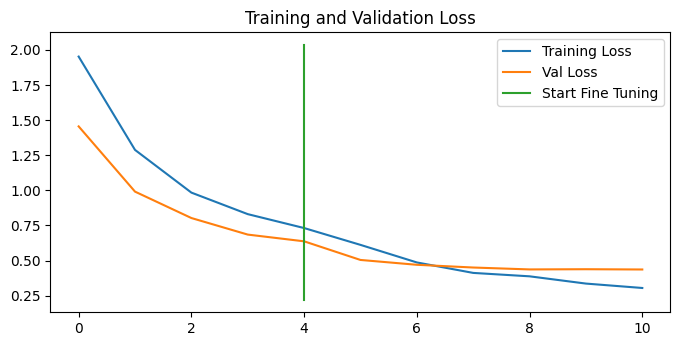

In [65]:
compare_histories(history_10_pct_data_aug, history_fine_tune_10_pct_data_aug, initial_epochs=5)

## Model 4: Fine-tuning an existing model on all of the data


In [66]:
# Download and unzip 10 classes of Food101 data with all images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data("10_food_classes_all_data.zip")


--2023-08-17 18:49:23--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.12.128, 172.217.194.128, 142.250.4.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.12.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M  20.8MB/s    in 25s     

2023-08-17 18:49:49 (19.5 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [67]:
# Setup training and test dir
train_dir_all_data = "10_food_classes_all_data/train"
test_dir = "10_food_classes_all_data/test"

In [68]:
# How many images are we working now
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/train'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ramen'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_curry'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/pizza'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ice_cream'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/grilled_salmon'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/steak'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_wings'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/hamburger'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/sushi'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/fried_rice'.

In [69]:
# Setup data input
IMG_SIZE = (224, 224)
train_data_all = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir_all_data,
                                                                      image_size=IMG_SIZE,
                                                                      label_mode="categorical")
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode="categorical")
# train_data size =  750 * 10 classes
# test_data size =  250 * 10 classes

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


The test datset we have loded in is the same as what we've been using for previous experiments.

Let's verify this

In [70]:
# Evaluate model 2 (this is the fine-tune on 10% of data version)
model_2.evaluate(test_data)

79/79 [==============================] - 8s 90ms/step - loss: 0.4137 - accuracy: 0.8608


[0.4137150049209595, 0.86080002784729]

In [71]:
results_fine_tune_10_pct

[0.41371503472328186, 0.86080002784729]

To train a fine-tuning model (model 4) we need to revert model_2 back to its feature extraction weights.

Remember that fine-tuning starts from a feature extraction model.

#### Issues here

For TensorFlow 2.10.0+, you may encounter the problem as below:
```
ValueError: Received incompatible tensor with shape (1280, 10) when attempting to restore variable with shape (1, 1, 1152, 48) and name Adam/m/block7a_se_reduce/kernel:0.
```

One way to solve it is to uninstall you current version of tensorflow and install 2.9.0 version. (put it on the begining of this notebook)
```python
!pip uninstall -y tensorflow to remove the 2.12.x version

!pip install -U -q tensorflow==2.9.0
import tensorflow as tf
print(tf.version)
from tensorflow import keras

```
[Issue discussion](https://github.com/mrdbourke/tensorflow-deep-learning/issues/544)

In [72]:
# Load weights from checkpoint, that way we can fine-tune from the same stage the 10 percent data model (model 3) was fine-tuned from
model_2.load_weights(checkpoint_path)


In [73]:
checkpoint_path

'10_pct_model_checkpoints_weights/checkpoint'

In [74]:
model_2.evaluate(test_data)

79/79 [==============================] - 6s 70ms/step - loss: 0.6233 - accuracy: 0.8384


[0.6232820749282837, 0.8384000062942505]

In [75]:
# Check to see if our model_2 is reverted to feature extraction results
results_10_pct_data_aug

[0.6232821941375732, 0.8384000062942505]

What we have done here:
1. Trained a feature extraction transfer learning model for 5 epochs on 10% of the training data with data augmentation (model_2) and we saved the mdoel weights using `ModelCheckpoint` callback
2. Fine-tune the same model on the same 10% data for 5 more epochs with the top 10 layers of the base model unfrozen (model_3)
3. Saved the results and training logs each time
4. Reloaded the model from step 1 to do the same steps as step 2 but this time we use all data (model_4)


In [76]:
# Let's check layers are tunable (trainable)
for layer_number, layer in enumerate(model_2.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 global_average_pooling_2D True
4 output_layer True


In [77]:
# Let's drill into our base model
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_4 False
1 rescaling_3 False
2 normalization_3 False
3 tf.math.truediv_3 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeez

In [78]:
# Compile
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=["accuracy"])


In [79]:
# Continue fine-tune on the all data
fine_tune_epochs = initial_epochs+5

history_fine_tune_full = model_2.fit(train_data_all,
                                     epochs=fine_tune_epochs,
                                     validation_data=test_data,
                                     validation_steps=int(0.25*len(test_data)),
                                     initial_epoch=history_10_pct_data_aug.epoch[-1], # start from the end of previous training
                                     callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                            experiment_name="all_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/all_fine_tune_last_10/20230817-185014
Epoch 5/10
235/235 [==============================] - 75s 287ms/step - loss: 0.6468 - accuracy: 0.7913 - val_loss: 0.3409 - val_accuracy: 0.8865
Epoch 6/10
235/235 [==============================] - 60s 251ms/step - loss: 0.5231 - accuracy: 0.8325 - val_loss: 0.2881 - val_accuracy: 0.9062
Epoch 7/10
235/235 [==============================] - 55s 232ms/step - loss: 0.4598 - accuracy: 0.8544 - val_loss: 0.2734 - val_accuracy: 0.9112
Epoch 8/10
235/235 [==============================] - 56s 236ms/step - loss: 0.4157 - accuracy: 0.8684 - val_loss: 0.3048 - val_accuracy: 0.9013
Epoch 9/10
235/235 [==============================] - 45s 189ms/step - loss: 0.3811 - accuracy: 0.8731 - val_loss: 0.2721 - val_accuracy: 0.9062
Epoch 10/10
235/235 [==============================] - 48s 202ms/step - loss: 0.3473 - accuracy: 0.8904 - val_loss: 0.2741 - val_accuracy: 0.9211


In [80]:
results_fine_tune_10_pct

[0.41371503472328186, 0.86080002784729]

In [81]:
# Let's evaluate it on the all test data
results_fine_tune_full_data = model_2.evaluate(test_data)
results_fine_tune_full_data

79/79 [==============================] - 6s 69ms/step - loss: 0.2649 - accuracy: 0.9132


[0.26488882303237915, 0.9132000207901001]

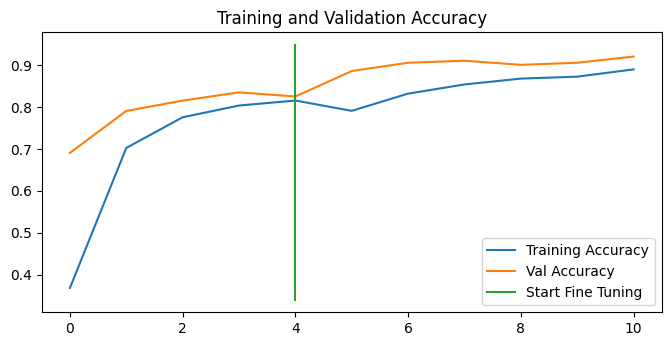

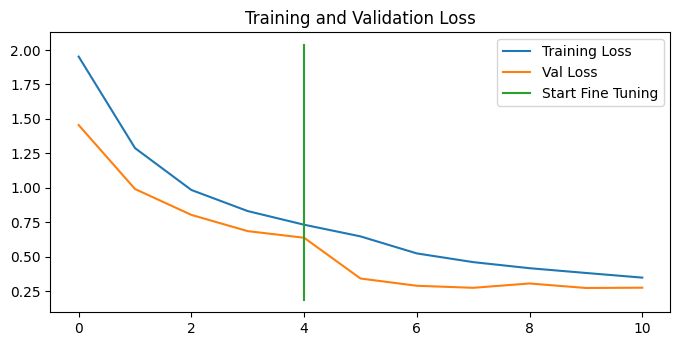

In [82]:
# How did fine-tuning go with more data?
compare_histories(history_10_pct_data_aug, history_fine_tune_full, initial_epochs=5)

See! The POWER of **transfer learning**!🎉🎉

## Compare all our models on TensorBoard

> **Note:** Anything you upload to TensorBoard.dev is going to be public. So if you have private data, do not upload.

In [86]:
# View tensorboard logs of transfer learning modelling experiments
# Upload TensorBoard dev
!tensorboard dev upload --logdir ./transfer_learning/ --name "Transfer Learning Experiments with 10 Food101 Classes" --description "A series of different transfer learning experiments with varying amount of data" --one_shot



New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/ROOFkeT1TBKHpzpqFoRatQ/

[2023-08-17T18:59:34] Started scanning logdir.
[2023-08-17T18:59:45] Total uploaded: 192 scalars, 0 tensors, 6 binary objects (4.9 MB)
[2023-08-17T18:59:45] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/ROOFkeT1TBKHpzpqFoRatQ/


My TensorFlowBoard experiments are available at:

**Note:** You may ran into this bug if you are using lower version of tensorboard: *Access blocked: TensorBoard.dev's request is invalid.* One way to solve it is to upload your tensorboard with:
`pip install -U tensorboard`

In [84]:
!pip install -U tensorboard
!tensorboard --version

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 33.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 77.3 MB/s eta 0:00:00
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.6.1
    Uninstalling tensorboard-data-server-0.6.1:
      Successfully uninstalled tensorboard-data-server-0.6.1
  Attempting uninstall: google-auth-oauthlib
    Found existing installation: google-auth-oauthlib 0.4.6
    Uninstalling google-auth-oauthlib-0.4.6:
      Successfully uninstalled google-auth-oauthlib-0.4.6
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      Successfully uninstalled tensorboard-2.9.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.9.0 requires tensorboard<2.10,>=2.9, but you have tens

2.14.0


In [87]:
!tensorboard dev list

https://tensorboard.dev/experiment/ROOFkeT1TBKHpzpqFoRatQ/
	Name                 Transfer Learning Experiments with 10 Food101 Classes
	Description          A series of different transfer learning experiments with varying amount of data
	Id                   ROOFkeT1TBKHpzpqFoRatQ
	Created              2023-08-17 18:59:34 (1 minute ago)
	Updated              2023-08-17 18:59:45 (1 minute ago)
	Runs                 12
	Tags                 5
	Scalars              192
	Tensor bytes         0
	Binary object bytes  5172346
https://tensorboard.dev/experiment/aJUqjNfOTdmzOI6Ve0HR1Q/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different TF Hub Feature extraction model architectures using 10% of the training data
	Id                   aJUqjNfOTdmzOI6Ve0HR1Q
	Created              2023-08-07 18:40:28
	Updated              2023-08-07 18:40:32
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object 

# Transfer Learning Part 2: Exercise

Review of first several models:
1. `model_1` -  use feature extraction transfer learning with 1% training data with data augmentation.
2. `model_2` - use feature extraction transfer learning with 10% training data with data augmentation.
3. `model_3` - use fine-tuning transfer learning on 10% of the training data with data augmentation
4. `model_4` - use fine-tuning learning on 100% of traininig data with data augmentation

## Excercise 1
Use feature-extraction to train a transfer learning model on 10% of the Food Vision data for 10 epochs using tf.keras.applications.EfficientNetB0 as the base model. Use the ModelCheckpoint callback to save the weights to file.

```python
# Set checkpoint path
checkpoint_path = "10_pct_model_checkpoints_weights/checkpoint"

# Create a ModelCheckpoint Callback that saves the model's weights only (quicker)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=False, # if it is ture, it will only save weights that results the smallest val_loss (default)
                                                         save_freq='epoch', # save every epoch
                                                         verbose=1)
```

>The directory of the filepath should not be reused by any other callbacks to avoid conflicts.

In [93]:
# prepare 10pct data
train_dir_10_pct = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

train_data_10_pct = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_pct,
                                                                        label_mode="categorical",
                                                                        image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)


Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [88]:
# Set checkpoint path
checkpoint_path = "10_pct_model_cp_weights_10_epochs/checkpoint"

# create a checkpoint callback
checkpoint_callback_10_epochs = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                                   save_weights_only=True,
                                                                   save_best_only=True,
                                                                   save_freq='epoch',
                                                                   verbose=1)

In [104]:
train_data_10_pct.take(2)

<TakeDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

```python
# Create the inouts and outputs
inputs = layers.Input(shape=input_shape, name='input_layer')
x = data_augmentation(inputs)
x = base_model(x, training=False) # pass the augmented images to base model but keep the base model in inference mode, this also ensures batchnorm layers don't get updated
x = layers.GlobalAveragePooling2D(name="global_average_pooling_2D")(x)
outputs = layers.Dense(10, activation='softmax', name="output_layer")(x)

model_2 = tf.keras.Model(inputs, outputs)
```
⚠️ If I use `AveragePooling2D(name="Average_pooling_layer")(x)` to pooling inputs, it will result in the problem below:
```
ValueError: Shapes (None, 10) and (None, None, None, 10) are incompatible
```

In [109]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False ### Attention!

# input
inputs= layers.Input(shape=(224, 224, 3), name="input_layer")

# this step is to add inputs as a layer so it is in the first ()
x = data_augmentation(inputs)
x = base_model(x, training=False)
# AveragePooling2D(name="Average_pooling_layer")(x)
x = layers.GlobalAveragePooling2D(name="Average_pooling_layer")(x)
outputs = layers.Dense(10, activation='softmax', name="output_layer")(x)

model_3 = tf.keras.Model(inputs, outputs)

# Compile model
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [112]:
# Fitting the model with checkpoint. callback
history_10_pct_10_epochs = model_3.fit(train_data_10_pct, epochs=10,
                                       steps_per_epoch=len(train_data_10_pct),
                                       validation_data=test_data,
                                       validation_steps=int(0.20*len(test_data)),
                                       callbacks=[checkpoint_callback_10_epochs])

Epoch 1/10
24/24 [==============================] - ETA: 0s - loss: 1.8625 - accuracy: 0.4320
Epoch 1: val_loss improved from inf to 1.36455, saving model to 10_pct_model_cp_weights_10_epochs/checkpoint
24/24 [==============================] - 15s 290ms/step - loss: 1.8625 - accuracy: 0.4320 - val_loss: 1.3645 - val_accuracy: 0.6938
Epoch 2/10
24/24 [==============================] - ETA: 0s - loss: 1.2441 - accuracy: 0.7067
Epoch 2: val_loss improved from 1.36455 to 0.94447, saving model to 10_pct_model_cp_weights_10_epochs/checkpoint
24/24 [==============================] - 7s 285ms/step - loss: 1.2441 - accuracy: 0.7067 - val_loss: 0.9445 - val_accuracy: 0.7979
Epoch 3/10
24/24 [==============================] - ETA: 0s - loss: 0.9534 - accuracy: 0.7693
Epoch 3: val_loss improved from 0.94447 to 0.79655, saving model to 10_pct_model_cp_weights_10_epochs/checkpoint
24/24 [==============================] - 8s 308ms/step - loss: 0.9534 - accuracy: 0.7693 - val_loss: 0.7966 - val_accura

In [115]:
results_10_pct_dataaug_10_epochs = model_3.evaluate(test_data)
results_10_pct_dataaug_10_epochs

79/79 [==============================] - 11s 128ms/step - loss: 0.4934 - accuracy: 0.8664


[0.493428111076355, 0.8664000034332275]

In [114]:
results_10_pct_data_aug

[0.6232821941375732, 0.8384000062942505]

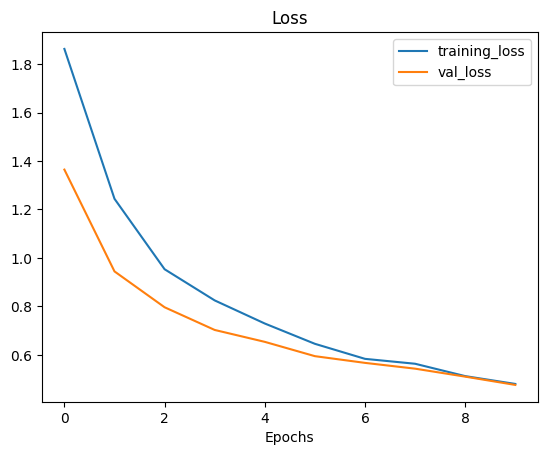

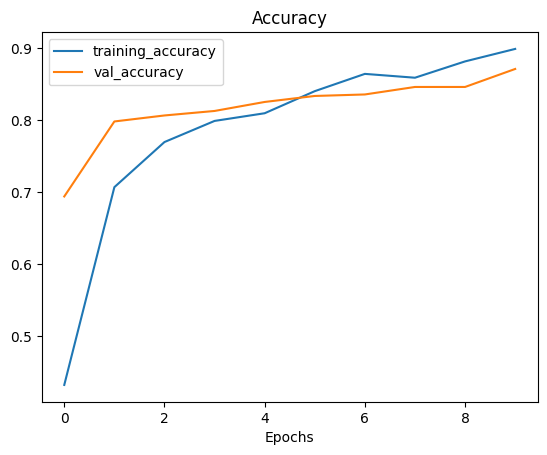

In [116]:
plot_loss_curves(history_10_pct_10_epochs)

### Conclusion

Fitting model_3 (basically the same as model_2) get a better results with around 3% increase in accuracy. And checking the loss curves, the losses of both training and testing are about to merge, and the accuracy seems to have more space to increase if we fitting for more epochs.

## Exercise 2
Fine-tune the last 20 layers of the base model you trained in 2 for another 10 epochs. How did it go?

codes to unfreeze the base model:
```python
# To begin with, let's start by setting the last 10 layers of our base_model to trainable
base_model.trainable = True

# Freeze all layers except for the last 10
for layer in base_model.layers[:-10]:
  layer.trainable = False

# Recompile (we have to recompile our model every time we make a change)
model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # when fine-tuning, you would wan to lower the learning rate by 10x
                metrics=["accuracy"])
```

In [117]:
# Unfreeze all layers
base_model.trainable=True

# Freeze all except for the last 20
for layer in base_model.layers[:-20]:
  layer.trainable=False

In [118]:
# Recompile model_3 and decrease a bit of the training rate
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=["accuracy"])

In [128]:
for i, layer in enumerate(model_3.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_13 False
1 rescaling_12 False
2 normalization_12 False
3 tf.math.truediv_12 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_sq

Code for fine-tuning
```python
# Fine-tune for another 5 epochs
fine_tune_epochs = initial_epochs+5

# Refit the model (same as model_2 except with more trainable layers)
# model_2 is a feature extraction model
history_fine_tune_10_pct_data_aug = model_2.fit(train_data_10_pct,
                                                epochs=fine_tune_epochs,
                                                validation_data=test_data,
                                                validation_steps=int(0.25*len(test_data)),
                                                initial_epoch=history_10_pct_data_aug.epoch[-1], # start training from previous last epochs
                                                callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                       experiment_name="10_percent_fine_tune_last_10_layers")])
 ```

In [131]:
# fine-tune for another 10 epochs
fine_tune_epochs = 20

# refit the model
history_10_pct_fine_tune_10_epochs = model_3.fit(train_data_10_pct,
            epochs=fine_tune_epochs,
            validation_data=test_data,
            validation_steps=int(0.20*len(test_data)),
            initial_epoch=history_10_pct_10_epochs.epoch[-1] # cuz sometimes we're not sure how many epochs the model has been trained
            )

Epoch 10/20
24/24 [==============================] - 9s 346ms/step - loss: 0.0628 - accuracy: 0.9827 - val_loss: 0.5184 - val_accuracy: 0.8458
Epoch 11/20
24/24 [==============================] - 8s 321ms/step - loss: 0.0707 - accuracy: 0.9800 - val_loss: 0.3948 - val_accuracy: 0.8750
Epoch 12/20
24/24 [==============================] - 8s 302ms/step - loss: 0.0482 - accuracy: 0.9973 - val_loss: 0.4366 - val_accuracy: 0.8646
Epoch 13/20
24/24 [==============================] - 5s 212ms/step - loss: 0.0430 - accuracy: 0.9920 - val_loss: 0.4094 - val_accuracy: 0.8813
Epoch 14/20
24/24 [==============================] - 7s 256ms/step - loss: 0.0382 - accuracy: 0.9933 - val_loss: 0.4925 - val_accuracy: 0.8625
Epoch 15/20
24/24 [==============================] - 6s 235ms/step - loss: 0.0308 - accuracy: 0.9960 - val_loss: 0.4645 - val_accuracy: 0.8646
Epoch 16/20
24/24 [==============================] - 6s 236ms/step - loss: 0.0348 - accuracy: 0.9960 - val_loss: 0.4507 - val_accuracy: 0.8708

In [129]:
results_10_pct_fine_tune_10_epochs = model_3.evaluate(test_data)

79/79 [==============================] - 12s 138ms/step - loss: 0.4667 - accuracy: 0.8624


In [130]:
results_10_pct_dataaug_10_epochs

[0.493428111076355, 0.8664000034332275]

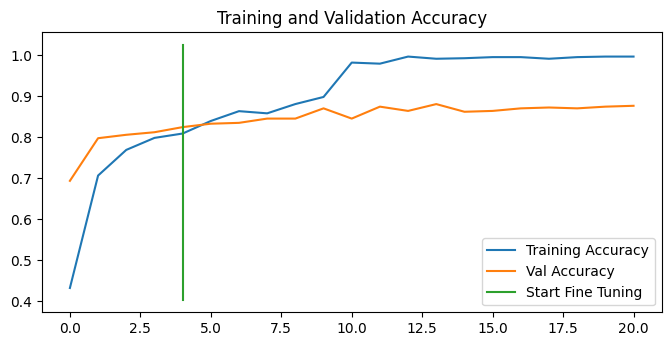

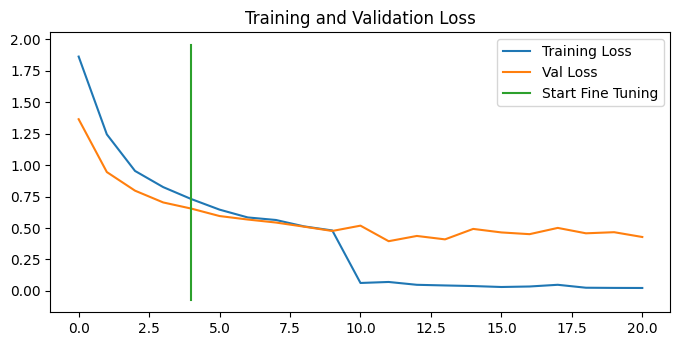

In [132]:
compare_histories(history_10_pct_10_epochs, history_10_pct_fine_tune_10_epochs)

### Conclusion

Checking the loss curves, the accuracy of training datasets has a sharp increase after 10 more fin-tuning epochs, while the accuracy of test dataset doesn't change any bit. **That means there is a overfitting.**

Therefore, fine-tuning is not always helpful. Especially when there has already had a close accuracy and loss curves of training and testing dataset.